<a href="https://colab.research.google.com/github/TemsyChen/DS-Unit-2-Applied-Modeling/blob/master/TemsyChen_LS_DS_232_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets

- [ ] Continue to clean and explore your data. 
- [ ] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

#Wildfire Trends

This dataset is from a [Buzzfeed article](https://buzzfeednews.github.io/2018-07-wildfire-trends/) that contains data from Cal Fire and the US Forest service.

###Import Libraries and Dataset

In [1]:
#pip installs
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*

     |████████████████████████████████| 81kB 3.3MB/s 
     |████████████████████████████████| 266kB 5.4MB/s 
     |████████████████████████████████| 3.1MB 5.9MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 604kB 31.2MB/s 
     |████████████████████████████████| 296kB 21.6MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=aff977669f9152f1eaab89e58a9256db988db39fe109f93c22aff7b1e7c02025
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built htmlmin
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: pandas-profiling 1.4.1
    Uninstalling pandas-profiling-1.4.1:
      Successfully uninstalled pandas-profiling-1.4.1


In [2]:
#Libraries
import pandas as pd
import numpy as np
from datetime import datetime 

from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#Display settings
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Import the Cal Fire dataset

frap = pd.read_csv('https://raw.githubusercontent.com/BuzzFeedNews/2018-07-wildfire-trends/master/data/calfire_frap.csv')

Dictionary of terms:

YEAR

STATE

AGENCY

UNIT_ID

FIRE_NAME

INC_NUM (incident number)

ALARM_DATE

CONT_DATE (containment date)

CAUSE - 

1  ~ "Natural",

13 | is.na(stat_cause_code) ~ "Unknown",
                           
code >= 2 | stat_cause_code <= 12 ~ "Human"

COMMENTS

REPORT_AC (reported number of acres burned)

GIS_ACRES (number of acres burned as determined by analysis of GIS data)

C_METHOD (containment method?)

OBJECTIVE

###EDA

Notes: I'll use "gis_acres" as the target, to predict the size of wildfires in CA, using a regression model.

In [4]:
frap

#Features to drop:
#'objectid' seems like index, but it doesn't match index.
#'state' is either CA, NV, or NaN
#'inc_num' is Incident Number, just another ID
#'comments', high cardinality
#'report_ac' is reported number of acres burned, data leakage
#'objective' couldn't find what this means
#'fire_num' couldn't find what this means
#'shape length' assuming this is the size of the fire, data leakage
#'shape_area' assuming this is the size of the fire, data leakage

objectid  year_ state agency unit_id     fire_name  inc_num  \
0             1   2007    CA    CCO     LAC       OCTOBER   246393   
1             2   2007    CA    CCO     LAC         MAGIC   233077   
2             3   2007    CA    USF     ANF         RANCH      166   
3             4   2007    CA    CCO     LAC          EMMA   201384   
4             5   2007    CA    CCO     LAC        CORRAL   259483   
...         ...    ...   ...    ...     ...           ...      ...   
14842     20711   2017    CA    USF     ENF         FORNI    23406   
14843     20712   2017    CA    DOD     MCP  CRISTIANITOS  1702047   
14844     20713   2014   NaN    USF     KNF         RIVER  1706227   
14845     20714   2014   NaN    USF     KNF         ETHEL     5977   
14846     20715   2016   NaN    USF     SHF          MILL      802   

       alarm_date   cont_date  cause  \
0      2007-10-21  2007-10-23   14.0   
1      2007-10-22  2007-10-25   14.0   
2      2007-10-20  2007-11-15    2.0   
3      2007-09-11  2007-09-11   14.0   
4      2007-11-24  2007-11-27   14.0   
...           ...         ...    ...   
14842  2017-08-11  2017-08-14   14.0   
14843  2017-06-28  2017-06-30    9.0   
14844  2014-05-02  2014-05-12    9.0   
14845  2014-08-12  2014-09-15    1.0   
14846  2016-05-19  2016-05-20    9.0   

                                           comments  report_ac     gis_acres  \
0                                               NaN        NaN     25.736713   
1                                               NaN        NaN   2824.877197   
2                                               NaN    54716.0  58410.335938   
3                                               NaN        NaN    172.214951   
4                                               NaN        NaN   4707.997070   
...                                             ...        ...           ...   
14842                          maybe campfire start        7.5     12.267185   
14843                         started by RC bicycle        NaN    702.306641   
14844  perimeter for 2014, not previously submitted       17.0     16.001045   
14845  perimeter for 2014, not previously submitted       13.8     11.619938   
14846  perimeter for 2016, not previously submitted       56.0     57.677917   

       c_method  objective fire_num   shape_length    shape_area  
0           8.0        1.0   233414    1902.439051  1.041528e+05  
1           8.0        1.0   233077   20407.965662  1.143187e+07  
2           7.0        1.0      166  169150.715690  2.363782e+08  
3           8.0        1.0   201384    6117.777086  6.969292e+05  
4           8.0        1.0   259483   22907.182174  1.905259e+07  
...         ...        ...      ...            ...           ...  
14842       8.0        1.0      NaN     923.961025  4.964354e+04  
14843       5.0        1.0      NaN   14502.847837  2.842134e+06  
14844       1.0        1.0      NaN    1189.931592  6.475393e+04  
14845       6.0        1.0      NaN     868.597134  4.702422e+04  
14846       1.0        1.0      NaN    2526.086042  2.334143e+05  

[14847 rows x 18 columns]

In [5]:
frap.shape

(14847, 18)

In [6]:
frap.describe()

#'gis_acres' is right skewed

objectid         year_         cause      report_ac      gis_acres  \
count  14847.000000  14847.000000  14805.000000    7088.000000   14841.000000   
mean   11631.642150   1988.606318      8.796082    2146.328182    1730.762064   
std     5375.934738     20.122024      5.326349   13293.335145    9878.159960   
min        1.000000   1950.000000      1.000000       0.000000       0.001357   
25%     8025.500000   1973.000000      2.000000      17.450000      25.658598   
50%    11879.000000   1991.000000      9.000000      67.960000     142.552170   
75%    16220.500000   2007.000000     14.000000     400.000000     624.751709   
max    20715.000000   2017.000000     19.000000  499945.000000  501082.031250   

          c_method     objective   shape_length    shape_area  
count  7494.000000  14672.000000   14847.000000  1.484700e+04  
mean      4.692554      1.017993    8858.614211  7.001315e+06  
std       3.100902      0.132932   19622.262001  3.996766e+07  
min       1.000000      1.000000       8.838431  5.491126e+00  
25%       1.000000      1.000000    1594.310671  1.033449e+05  
50%       6.000000      1.000000    3846.212541  5.764822e+05  
75%       8.000000      1.000000    8454.143860  2.526163e+06  
max       8.000000      2.000000  445282.444798  2.027807e+09

In [7]:
frap.info()

#Need to impute:
#cont_date (containment date)
#alarm_date
#cause

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14847 entries, 0 to 14846
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   objectid      14847 non-null  int64  
 1   year_         14847 non-null  int64  
 2   state         14844 non-null  object 
 3   agency        14842 non-null  object 
 4   unit_id       14837 non-null  object 
 5   fire_name     11944 non-null  object 
 6   inc_num       14262 non-null  object 
 7   alarm_date    13230 non-null  object 
 8   cont_date     7361 non-null   object 
 9   cause         14805 non-null  float64
 10  comments      1875 non-null   object 
 11  report_ac     7088 non-null   float64
 12  gis_acres     14841 non-null  float64
 13  c_method      7494 non-null   float64
 14  objective     14672 non-null  float64
 15  fire_num      12131 non-null  object 
 16  shape_length  14847 non-null  float64
 17  shape_area    14847 non-null  float64
dtypes: float64(7), int64(2), o

In [8]:
from pandas_profiling import ProfileReport

#import pandas_profiling
profile = ProfileReport(frap, minimal=True)

profile

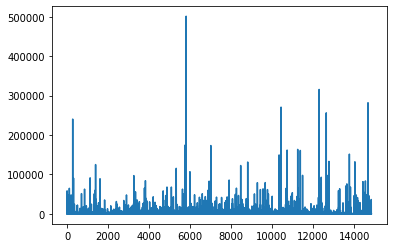

In [9]:
frap['gis_acres'].plot()

#what is on the x axis?

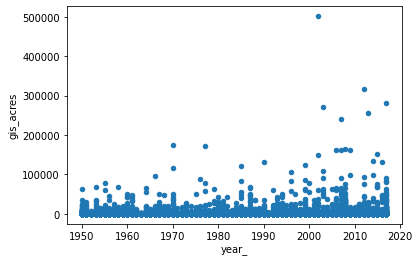

In [10]:
frap.plot.scatter(x='year_', y='gis_acres')

###Data Wrangling

In [60]:
frap.columns

Index(['objectid', 'year', 'state', 'agency', 'unit_id', 'fire_name',
       'inc_num', 'alarm_date', 'cont_date', 'cause', 'comments', 'report_ac',
       'gis_acres', 'c_method', 'objective', 'fire_num', 'shape_length',
       'shape_area'],
      dtype='object')

In [61]:
#change 'year_' to 'year'

frap = frap.rename(columns={'year_':'year'})

In [62]:
frap.head()

objectid  year state agency unit_id fire_name inc_num  alarm_date  \
0         1  2007    CA    CCO     LAC   OCTOBER  246393  2007-10-21   
1         2  2007    CA    CCO     LAC     MAGIC  233077  2007-10-22   
2         3  2007    CA    USF     ANF     RANCH     166  2007-10-20   
3         4  2007    CA    CCO     LAC      EMMA  201384  2007-09-11   
4         5  2007    CA    CCO     LAC    CORRAL  259483  2007-11-24   

    cont_date  cause comments  report_ac     gis_acres  c_method  objective  \
0  2007-10-23   14.0      NaN        NaN     25.736713       8.0        1.0   
1  2007-10-25   14.0      NaN        NaN   2824.877197       8.0        1.0   
2  2007-11-15    2.0      NaN    54716.0  58410.335938       7.0        1.0   
3  2007-09-11   14.0      NaN        NaN    172.214951       8.0        1.0   
4  2007-11-27   14.0      NaN        NaN   4707.997070       8.0        1.0   

  fire_num   shape_length    shape_area  
0   233414    1902.439051  1.041528e+05  
1   233077   20407.965662  1.143187e+07  
2      166  169150.715690  2.363782e+08  
3   201384    6117.777086  6.969292e+05  
4   259483   22907.182174  1.905259e+07

###Add US Forest service data set to complement Cal Fire data

In [14]:
#Import the US Forest service data set

fires1 = pd.read_csv('https://raw.githubusercontent.com/BuzzFeedNews/2018-07-wildfire-trends/master/data/us_fires/us_fires_1.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,11,12,14,15,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Fires: Table including wildfire data for the period of 1992-2015 compiled from US federal, state, and local reporting systems.

FOD_ID = Global unique identifier.

FPA_ID = Unique identifier that contains information necessary to track back to the original record in the source dataset.

SOURCE_SYSTEM_TYPE = Type of source database or system that the record was drawn from (federal, nonfederal, or interagency).

SOURCE_SYSTEM = Name of or other identifier for source database or system that the record was drawn from. See Table 1 in Short (2014), or \Supplements\FPA_FOD_source_list.pdf, for a list of sources and their identifier.

NWCG_REPORTING_AGENCY = Active National Wildlife Coordinating Group (NWCG) Unit Identifier for the agency preparing the fire report (BIA = Bureau of Indian Affairs, BLM = Bureau of Land Management, BOR = Bureau of Reclamation, DOD = Department of Defense, DOE = Department of Energy, FS = Forest Service, FWS = Fish and Wildlife Service, IA = Interagency Organization, NPS = National Park Service, ST/C&L = State, County, or Local Organization, and TRIBE = Tribal Organization).

NWCG_REPORTING_UNIT_ID = Active NWCG Unit Identifier for the unit preparing the fire report.

NWCG_REPORTING_UNIT_NAME = Active NWCG Unit Name for the unit preparing the fire report.

SOURCE_REPORTING_UNIT = Code for the agency unit preparing the fire report, based on code/name in the source dataset.

SOURCE_REPORTING_UNIT_NAME = Name of reporting agency unit preparing the fire report, based on code/name in the source dataset.

LOCAL_FIRE_REPORT_ID = Number or code that uniquely identifies an incident report for a particular reporting unit and a particular calendar year.

LOCAL_INCIDENT_ID = Number or code that uniquely identifies an incident for a particular local fire management organization within a particular calendar year.

FIRE_CODE = Code used within the interagency wildland fire community to track and compile cost information for emergency fire suppression (https://www.firecode.gov/).

FIRE_NAME = Name of the incident, from the fire report (primary) or ICS-209 report (secondary).

ICS_209_INCIDENT_NUMBER = Incident (event) identifier, from the ICS-209 report.

ICS_209_NAME = Name of the incident, from the ICS-209 report.

MTBS_ID = Incident identifier, from the MTBS perimeter dataset.

MTBS_FIRE_NAME = Name of the incident, from the MTBS perimeter dataset.

COMPLEX_NAME = Name of the complex under which the fire was ultimately managed, when discernible.

FIRE_YEAR = Calendar year in which the fire was discovered or confirmed to exist.

DISCOVERY_DATE = Date on which the fire was discovered or confirmed to exist.

DISCOVERY_DOY = Day of year on which the fire was discovered or confirmed to exist.

DISCOVERY_TIME = Time of day that the fire was discovered or confirmed to exist.

STAT_CAUSE_CODE = Code for the (statistical) cause of the fire.

STAT_CAUSE_DESCR = Description of the (statistical) cause of the fire.

CONT_DATE = Date on which the fire was declared contained or otherwise controlled (mm/dd/yyyy where mm=month, dd=day, and yyyy=year).

CONT_DOY = Day of year on which the fire was declared contained or otherwise controlled.

CONT_TIME = Time of day that the fire was declared contained or otherwise controlled (hhmm where hh=hour, mm=minutes).

FIRE_SIZE = Estimate of acres within the final perimeter of the fire.

FIRE_SIZE_CLASS = Code for fire size based on the number of acres within the final fire perimeter expenditures (A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres).

LATITUDE = Latitude (NAD83) for point location of the fire (decimal degrees).

LONGITUDE = Longitude (NAD83) for point location of the fire (decimal degrees).

OWNER_CODE = Code for primary owner or entity responsible for managing the land at the point of origin of the fire at the time of the incident.

OWNER_DESCR = Name of primary owner or entity responsible for managing the land at the point of origin of the fire at the time of the incident.

STATE = Two-letter alphabetic code for the state in which the fire burned (or originated), based on the nominal designation in the fire report.

COUNTY = County, or equivalent, in which the fire burned (or originated), based on nominal designation in the fire report.

FIPS_CODE = Three-digit code from the Federal Information Process Standards (FIPS) publication 6-4 for representation of counties and equivalent entities.

FIPS_NAME = County name from the FIPS publication 6-4 for representation of counties and equivalent entities.

In [15]:
fires1.head()

objectid  fod_id      fpa_id source_system_type source_system  \
0         1     1.0  FS-1418826                FED   FS-FIRESTAT   
1         2     2.0  FS-1418827                FED   FS-FIRESTAT   
2         3     3.0  FS-1418835                FED   FS-FIRESTAT   
3         4     4.0  FS-1418845                FED   FS-FIRESTAT   
4         5     5.0  FS-1418847                FED   FS-FIRESTAT   

  nwcg_reporting_agency nwcg_reporting_unit_id  nwcg_reporting_unit_name  \
0                    FS                USCAPNF    Plumas National Forest   
1                    FS                USCAENF  Eldorado National Forest   
2                    FS                USCAENF  Eldorado National Forest   
3                    FS                USCAENF  Eldorado National Forest   
4                    FS                USCAENF  Eldorado National Forest   

  source_reporting_unit source_reporting_unit_name  local_fire_report_id  \
0                   511     Plumas National Forest                   1.0   
1                   503   Eldorado National Forest                  13.0   
2                   503   Eldorado National Forest                  27.0   
3                   503   Eldorado National Forest                  43.0   
4                   503   Eldorado National Forest                  44.0   

  local_incident_id fire_code fire_name ics_209_incident_number ics_209_name  \
0            PNF-47      BJ8K  FOUNTAIN                     NaN          NaN   
1                13      AAC0    PIGEON                     NaN          NaN   
2               021      A32W     SLACK                     NaN          NaN   
3                 6       NaN      DEER                     NaN          NaN   
4                 7       NaN  STEVENOT                     NaN          NaN   

  mtbs_id mtbs_fire_name complex_name  fire_year       discovery_date  \
0     NaN            NaN          NaN       2005  2005-02-02T00:00:00   
1     NaN            NaN          NaN       2004  2004-05-12T00:00:00   
2     NaN            NaN          NaN       2004  2004-05-31T00:00:00   
3     NaN            NaN          NaN       2004  2004-06-28T00:00:00   
4     NaN            NaN          NaN       2004  2004-06-28T00:00:00   

   discovery_doy  discovery_time  stat_cause_code stat_cause_descr  \
0             33          1300.0                9    Miscellaneous   
1            133           845.0                1        Lightning   
2            152          1921.0                5   Debris Burning   
3            180          1600.0                1        Lightning   
4            180          1600.0                1        Lightning   

             cont_date  cont_doy  cont_time  fire_size fire_size_class  \
0  2005-02-02T00:00:00      33.0     1730.0       0.10               A   
1  2004-05-12T00:00:00     133.0     1530.0       0.25               A   
2  2004-05-31T00:00:00     152.0     2024.0       0.10               A   
3  2004-07-03T00:00:00     185.0     1400.0       0.10               A   
4  2004-07-03T00:00:00     185.0     1200.0       0.10               A   

    latitude   longitude  owner_code       owner_descr state county  \
0  40.036944 -121.005833           5              USFS    CA     63   
1  38.933056 -120.404444           5              USFS    CA     61   
2  38.984167 -120.735556          13  STATE OR PRIVATE    CA     17   
3  38.559167 -119.913333           5              USFS    CA      3   
4  38.559167 -119.933056           5              USFS    CA      3   

   fips_code  fips_name  
0       63.0     Plumas  
1       61.0     Placer  
2       17.0  El Dorado  
3        3.0     Alpine  
4        3.0     Alpine

In [16]:
fires1.shape

(300000, 38)

In [17]:
CA_fires1 = fires1[fires1['state']=='CA']

In [18]:
CA_fires1.shape

(45254, 38)

In [19]:
profile = ProfileReport(CA_fires1, minimal=True)

profile

In [20]:
#Drop not useful features

def wrangle(X):
  X = X.copy()

  cols_to_drop = ['objectid','source_system_type','source_system','nwcg_reporting_agency',
                  'nwcg_reporting_unit_id','nwcg_reporting_unit_name','source_reporting_unit','source_reporting_unit_name',
                  'local_incident_id','fire_code','ics_209_incident_number','ics_209_name','mtbs_id','mtbs_fire_name','complex_name',
                  'state','county','discovery_date','cont_date','fips_code','fips_name','owner_code','owner_descr']
  X = X.drop(columns=cols_to_drop)

  return X


In [21]:
CA_fires1 = wrangle(CA_fires1)

In [22]:
CA_fires1

fod_id      fpa_id  local_fire_report_id      fire_name  fire_year  \
0            1.0  FS-1418826                   1.0       FOUNTAIN       2005   
1            2.0  FS-1418827                  13.0         PIGEON       2004   
2            3.0  FS-1418835                  27.0          SLACK       2004   
3            4.0  FS-1418845                  43.0           DEER       2004   
4            5.0  FS-1418847                  44.0       STEVENOT       2004   
...          ...         ...                   ...            ...        ...   
298720  304316.0    W-596887                1301.0     RANGE LINE       2009   
298721  304317.0    W-596888                1302.0     BEAST LINE       2009   
298722  304318.0    W-597066                1309.0  STANDING ROCK       2009   
298725  304321.0    W-597771                1342.0      GRAVEYARD       2009   
298726  304322.0    W-597555                1352.0        JOURNEY       2009   

        discovery_doy  discovery_time  stat_cause_code stat_cause_descr  \
0                  33          1300.0                9    Miscellaneous   
1                 133           845.0                1        Lightning   
2                 152          1921.0                5   Debris Burning   
3                 180          1600.0                1        Lightning   
4                 180          1600.0                1        Lightning   
...               ...             ...              ...              ...   
298720            318          1027.0                5   Debris Burning   
298721            318          1150.0                7            Arson   
298722            321          1457.0                7            Arson   
298725            342          1725.0                7            Arson   
298726            350          1725.0                7            Arson   

        cont_doy  cont_time  fire_size fire_size_class   latitude   longitude  
0           33.0     1730.0       0.10               A  40.036944 -121.005833  
1          133.0     1530.0       0.25               A  38.933056 -120.404444  
2          152.0     2024.0       0.10               A  38.984167 -120.735556  
3          185.0     1400.0       0.10               A  38.559167 -119.913333  
4          185.0     1200.0       0.10               A  38.559167 -119.933056  
...          ...        ...        ...             ...        ...         ...  
298720     319.0     1600.0       0.50               B  32.753300 -114.605000  
298721     318.0     1600.0       0.10               A  32.741400 -114.599200  
298722     323.0     1600.0       0.50               B  32.739700 -114.603100  
298725     344.0     1600.0       0.30               B  32.757800 -114.611400  
298726     362.0     1600.0      32.40               C  32.796900 -114.607200  

[45254 rows x 15 columns]

In [23]:
#See if you can join the two datasets by fire name or ID

canyon_frap = frap[frap['fire_name']=='CANYON']
canyon_frap.head()

objectid  year state agency unit_id fire_name inc_num  alarm_date  \
23          24  2007    CA    CCO     LAC    CANYON  148415  2007-07-07   
187        188  2007    CA    BLM     BBD    CANYON    1568  2007-07-23   
2678      6798  1981    CA    USF     CNF    CANYON       0  1981-07-23   
3847      8164  1994    CA    USF     SQF    CANYON       0  1994-07-16   
3884      8201  1996    CA    USF     SQF    CANYON       0  1996-06-04   

       cont_date  cause comments  report_ac    gis_acres  c_method  objective  \
23           NaN   14.0      NaN      743.0   743.479919       NaN        1.0   
187   2007-06-24    9.0      NaN       84.7    84.723747       1.0        1.0   
2678         NaN    9.0      NaN        NaN    31.828991       NaN        1.0   
3847  1994-07-16    9.0      NaN       20.0    28.032465       8.0        1.0   
3884  1996-06-05    9.0      NaN     3328.0  3336.365479       8.0        1.0   

     fire_num  shape_length    shape_area  
23     148415  12308.866953  3.008757e+06  
187      1568   2693.526124  3.428648e+05  
2678       22   1453.845435  1.288074e+05  
3847       49   1401.531842  1.134434e+05  
3884       13  22859.051668  1.350179e+07

In [24]:
canyon_fires1 = CA_fires1[CA_fires1['fire_name']=='CANYON']
canyon_fires1.head()

fod_id      fpa_id  local_fire_report_id fire_name  fire_year  \
87        89.0  FS-1419071                  15.0    CANYON       2005   
8461    8503.0  FS-1434996                  13.0    CANYON       2006   
8611    8654.0  FS-1435188                  68.0    CANYON       2006   
10823  10873.0  FS-1438442                 137.0    CANYON       2006   
12857  12913.0  FS-1441232                 122.0    CANYON       2006   

       discovery_doy  discovery_time  stat_cause_code stat_cause_descr  \
87               114           710.0                9    Miscellaneous   
8461             176          1413.0                1        Lightning   
8611             166          1605.0                2    Equipment Use   
10823            224          1243.0                9    Miscellaneous   
12857            242          1122.0                9    Miscellaneous   

       cont_doy  cont_time  fire_size fire_size_class   latitude   longitude  
87        114.0      745.0       0.10               A  34.174444 -117.765000  
8461      176.0     2030.0      26.50               C  34.793333 -119.334167  
8611      166.0     1630.0       2.00               B  34.564444 -118.681944  
10823     224.0     1300.0      20.00               C  33.562500 -116.555556  
12857     242.0     1530.0       0.25               A  39.551944 -121.050000

Decided to use the dataset US_Fires instead of Cal Fires. The new targets will be 'cause'.

In [25]:
profile = ProfileReport(fires1, minimal=True)

profile

In [3]:
#Import the US Forest service data set

fires1 = pd.read_csv('https://raw.githubusercontent.com/BuzzFeedNews/2018-07-wildfire-trends/master/data/us_fires/us_fires_1.csv')
fires2 = pd.read_csv('https://raw.githubusercontent.com/BuzzFeedNews/2018-07-wildfire-trends/master/data/us_fires/us_fires_2.csv')
fires3 = pd.read_csv('https://raw.githubusercontent.com/BuzzFeedNews/2018-07-wildfire-trends/master/data/us_fires/us_fires_3.csv')
fires4 = pd.read_csv('https://raw.githubusercontent.com/BuzzFeedNews/2018-07-wildfire-trends/master/data/us_fires/us_fires_4.csv')
fires5 = pd.read_csv('https://raw.githubusercontent.com/BuzzFeedNews/2018-07-wildfire-trends/master/data/us_fires/us_fires_5.csv')
fires6 = pd.read_csv('https://raw.githubusercontent.com/BuzzFeedNews/2018-07-wildfire-trends/master/data/us_fires/us_fires_6.csv')
fires7 = pd.read_csv('https://raw.githubusercontent.com/BuzzFeedNews/2018-07-wildfire-trends/master/data/us_fires/us_fires_7.csv')

all_fires = [fires1, fires2, fires3, fires4, fires5, fires6, fires7]

fires = pd.concat(all_fires) 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,11,12,14,15,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12,16,17,18,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,11,12,13,14,15,18,25,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12,13,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivi

In [27]:
#Wrangle data for US Fires data

def wrangle(X):
  X = X.copy()

  #keep only fires in CA
  X = X[X['state']=='CA']

  #remove unique ID and constant features
  X = X.drop(columns=['objectid','fod_id','fpa_id','source_system_type','state'])

  return X

In [28]:
# all_fire_data = fires1, fires2, fires3, fires4, fires5, fires6, fires7

# for data in all_fire_data:
#   data = wrangle(data)

In [29]:
#Wrangle the fires data

fires = wrangle(fires)



In [30]:
fires.columns

Index(['source_system', 'nwcg_reporting_agency', 'nwcg_reporting_unit_id',
       'nwcg_reporting_unit_name', 'source_reporting_unit',
       'source_reporting_unit_name', 'local_fire_report_id',
       'local_incident_id', 'fire_code', 'fire_name',
       'ics_209_incident_number', 'ics_209_name', 'mtbs_id', 'mtbs_fire_name',
       'complex_name', 'fire_year', 'discovery_date', 'discovery_doy',
       'discovery_time', 'stat_cause_code', 'stat_cause_descr', 'cont_date',
       'cont_doy', 'cont_time', 'fire_size', 'fire_size_class', 'latitude',
       'longitude', 'owner_code', 'owner_descr', 'county', 'fips_code',
       'fips_name'],
      dtype='object')

In [31]:
fires.shape

(189550, 33)

In [32]:
fires.head()

source_system nwcg_reporting_agency nwcg_reporting_unit_id  \
0   FS-FIRESTAT                    FS                USCAPNF   
1   FS-FIRESTAT                    FS                USCAENF   
2   FS-FIRESTAT                    FS                USCAENF   
3   FS-FIRESTAT                    FS                USCAENF   
4   FS-FIRESTAT                    FS                USCAENF   

   nwcg_reporting_unit_name source_reporting_unit source_reporting_unit_name  \
0    Plumas National Forest                   511     Plumas National Forest   
1  Eldorado National Forest                   503   Eldorado National Forest   
2  Eldorado National Forest                   503   Eldorado National Forest   
3  Eldorado National Forest                   503   Eldorado National Forest   
4  Eldorado National Forest                   503   Eldorado National Forest   

  local_fire_report_id local_incident_id fire_code fire_name  \
0                    1            PNF-47      BJ8K  FOUNTAIN   
1                   13                13      AAC0    PIGEON   
2                   27               021      A32W     SLACK   
3                   43                 6       NaN      DEER   
4                   44                 7       NaN  STEVENOT   

  ics_209_incident_number ics_209_name mtbs_id mtbs_fire_name complex_name  \
0                     NaN          NaN     NaN            NaN          NaN   
1                     NaN          NaN     NaN            NaN          NaN   
2                     NaN          NaN     NaN            NaN          NaN   
3                     NaN          NaN     NaN            NaN          NaN   
4                     NaN          NaN     NaN            NaN          NaN   

   fire_year       discovery_date  discovery_doy  discovery_time  \
0       2005  2005-02-02T00:00:00             33          1300.0   
1       2004  2004-05-12T00:00:00            133           845.0   
2       2004  2004-05-31T00:00:00            152          1921.0   
3       2004  2004-06-28T00:00:00            180          1600.0   
4       2004  2004-06-28T00:00:00            180          1600.0   

   stat_cause_code stat_cause_descr            cont_date  cont_doy  cont_time  \
0                9    Miscellaneous  2005-02-02T00:00:00      33.0     1730.0   
1                1        Lightning  2004-05-12T00:00:00     133.0     1530.0   
2                5   Debris Burning  2004-05-31T00:00:00     152.0     2024.0   
3                1        Lightning  2004-07-03T00:00:00     185.0     1400.0   
4                1        Lightning  2004-07-03T00:00:00     185.0     1200.0   

   fire_size fire_size_class   latitude   longitude  owner_code  \
0       0.10               A  40.036944 -121.005833           5   
1       0.25               A  38.933056 -120.404444           5   
2       0.10               A  38.984167 -120.735556          13   
3       0.10               A  38.559167 -119.913333           5   
4       0.10               A  38.559167 -119.933056           5   

        owner_descr county  fips_code  fips_name  
0              USFS     63       63.0     Plumas  
1              USFS     61       61.0     Placer  
2  STATE OR PRIVATE     17       17.0  El Dorado  
3              USFS      3        3.0     Alpine  
4              USFS      3        3.0     Alpine

In [33]:
fires.describe()

fire_year  discovery_doy  discovery_time  stat_cause_code  \
count  189550.000000  189550.000000   110217.000000    189550.000000   
mean     2003.118275     201.594571     1383.752742         5.690725   
std         7.007634      65.936299      490.324275         3.677568   
min      1992.000000       1.000000        0.000000         1.000000   
25%      1997.000000     164.000000     1115.000000         2.000000   
50%      2003.000000     202.000000     1428.000000         5.000000   
75%      2009.000000     245.000000     1715.000000         9.000000   
max      2015.000000     366.000000     2359.000000        13.000000   

           cont_doy     cont_time      fire_size       latitude  \
count  91908.000000  91198.000000  189550.000000  189550.000000   
mean     203.607727   1474.324042      67.242725      37.434167   
std       65.127623    508.483440    2029.960435       2.591567   
min        1.000000      0.000000       0.001000      32.537406   
25%      169.000000   1200.000000       0.100000      35.177688   
50%      206.000000   1530.000000       0.250000      37.565062   
75%      246.000000   1810.000000       1.000000      39.475208   
max      366.000000   2359.000000  315578.800000      42.051667   

           longitude     owner_code     fips_code  
count  189550.000000  189550.000000  56221.000000  
mean     -120.182292      10.767038     56.633518  
std         2.155615       4.402412     30.041381  
min      -124.402883       0.000000      1.000000  
25%      -121.721944       6.000000     35.000000  
50%      -120.530316      14.000000     61.000000  
75%      -118.595503      14.000000     73.000000  
max      -114.125800      15.000000    115.000000

In [34]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189550 entries, 0 to 80464
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   source_system               189550 non-null  object 
 1   nwcg_reporting_agency       189550 non-null  object 
 2   nwcg_reporting_unit_id      189550 non-null  object 
 3   nwcg_reporting_unit_name    189550 non-null  object 
 4   source_reporting_unit       189550 non-null  object 
 5   source_reporting_unit_name  189550 non-null  object 
 6   local_fire_report_id        61933 non-null   object 
 7   local_incident_id           127983 non-null  object 
 8   fire_code                   55522 non-null   object 
 9   fire_name                   174555 non-null  object 
 10  ics_209_incident_number     2838 non-null    object 
 11  ics_209_name                2838 non-null    object 
 12  mtbs_id                     1137 non-null    object 
 13  mtbs_fire_name 

In [35]:
profile = ProfileReport(fires, minimal=True)

profile

##Make a baseline to guess the 'cause' of the fires

##Cause is in two columns: 'stat_cause_code' and 'stat_cause_descr'

##This is a categorical model

In [36]:
fires['stat_cause_code'].value_counts(normalize=True)

#Majority class is #9 at 27%

9     0.274033
2     0.207898
1     0.142443
7     0.103587
5     0.075537
13    0.066500
4     0.050203
8     0.036560
3     0.031316
11    0.006320
6     0.003798
10    0.001155
12    0.000649
Name: stat_cause_code, dtype: float64

In [37]:
#Do a time-based split on the data
#70% train, 20% validation, 10% test
#There are 189550 rows

first_split = int(189550*.7)
second_split = int(189550*.9)

print('Split the training data on the year for row:', first_split)
print('Split the validation data on the year for row:', second_split,'\n')

print("First date marker between train and val set:", fires['fire_year'].sort_values(ascending=True).iloc[first_split])
print('First date marker between val and test set:', fires['fire_year'].sort_values(ascending=True).iloc[second_split])

Split the training data on the year for row: 132685
Split the validation data on the year for row: 170595 

First date marker between train and val set: 2008
First date marker between val and test set: 2013


In [38]:
train = fires[fires['fire_year']<=2008]
val = fires[(fires['fire_year']>2008)&(fires['fire_year']<=2013)]
test = fires[fires['fire_year']>2013]

In [39]:
train.shape, val.shape, test.shape

((138482, 33), (37209, 33), (13859, 33))

In [40]:
#Set target, X matrices, y vectors

target = 'stat_cause_code'

features_df = train.drop(['stat_cause_code','stat_cause_descr'], axis=1)
features = features_df.columns.tolist()

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((138482, 31), (138482,), (37209, 31), (37209,), (13859, 31), (13859,))

##Make a Logistic Regression model

In [53]:
model = make_pipeline(OrdinalEncoder(),
                      SimpleImputer(),
                      RandomForestClassifier(n_jobs=-1,
                                             random_state=37))

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['source_system', 'nwcg_reporting_agency',
                                      'nwcg_reporting_unit_id',
                                      'nwcg_reporting_unit_name',
                                      'source_reporting_unit',
                                      'source_reporting_unit_name',
                                      'local_fire_report_id',
                                      'local_incident_id', 'fire_code',
                                      'fire_name', 'ics_209_incident_number',
                                      'ics_209_name', 'mtbs_id',
                                      'mtbs_fire_name', 'co...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                     

In [42]:
#Check metrics

print('Training  accuracy:', model.score(X_train, y_train))
print('Validation accuracy:', model.score(X_val, y_val))

Training  accuracy: 1.0
Validation accuracy: 0.37257115214061115


In [49]:
#Hyperparameter tuning

from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_distributions = {
    'simpleimputer__strategy': ['mean','median'],
    'randomforestclassifier__n_estimators': randint(1, 500),
    'randomforestclassifier__max_depth': [10,20,30,40,50,None],
    'randomforestclassifier__max_features': uniform(0,1)
}

search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=3,
    cv=3,
)

search.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: Future

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['source_system',
                                                                   'nwcg_reporting_agency',
                                                                   'nwcg_reporting_unit_id',
                                                                   'nwcg_reporting_unit_name',
                                                                   'source_reporting_unit',
                                                                   'source_reporting_unit_name',
                                                                   'local_fire_report_id',
                                                                   'local_incident_id',
                                                                   'fire_code',
                               

In [50]:
print('Best hyperparameters', search.best_params_)
print('Cross validation best score', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 40, 'randomforestclassifier__max_features': 0.16927733645558207, 'randomforestclassifier__n_estimators': 233, 'simpleimputer__strategy': 'median'}
Cross validation best score 0.11387796509343863


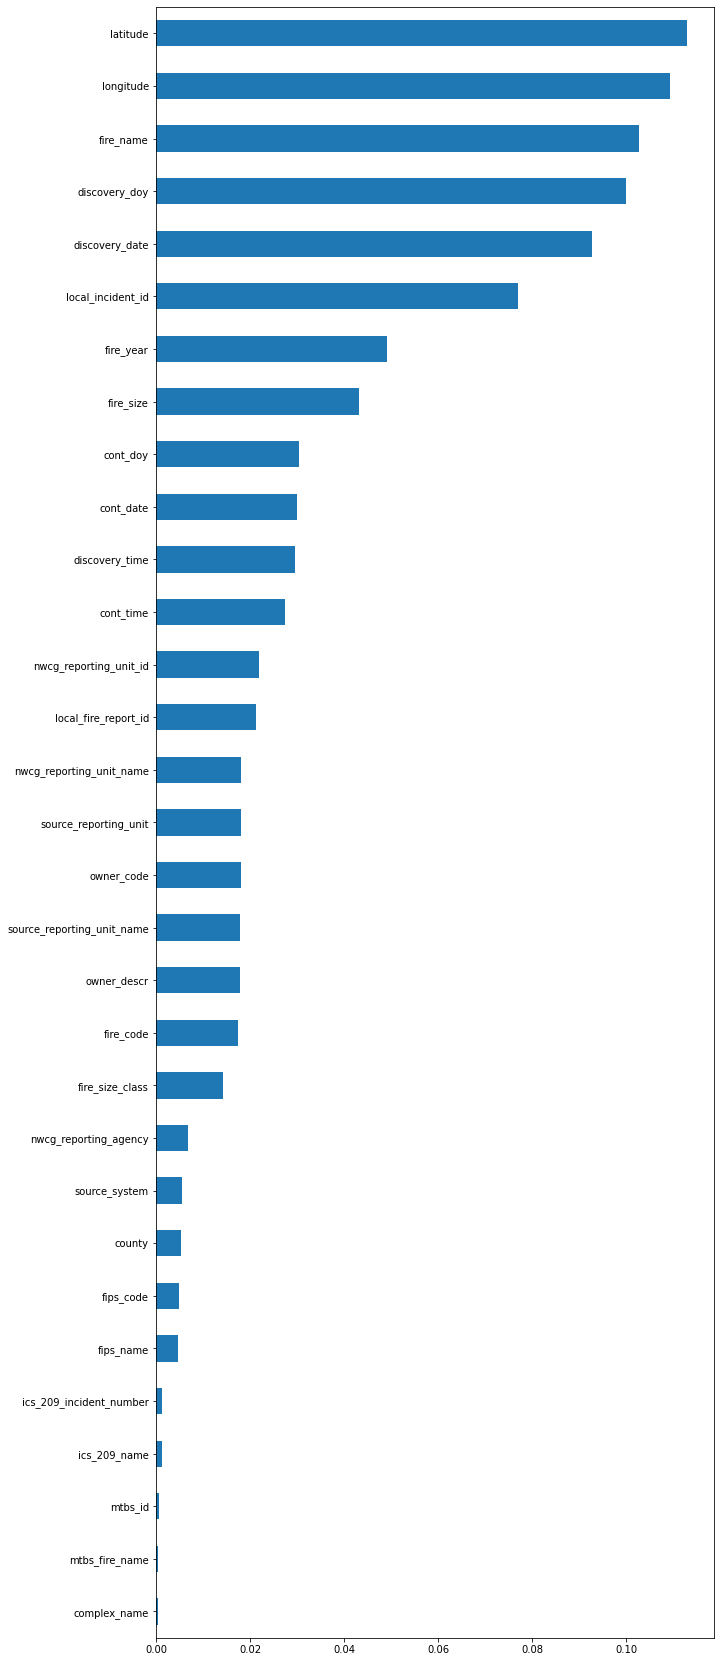

In [59]:
#Get feature importances
import matplotlib.pyplot as plt


feat_imp = model.named_steps['randomforestclassifier']

encoder = model.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(feat_imp.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();

In [7]:
#Try the model again, but take away data leaks
#Drop all columns except: Latitude, Longitude, Discovery_doy, discovery_date, fire_year, discovery_time, county

fires = pd.concat(all_fires) 

def wrangle(X):
  X = X.copy()

  #keep only fires in CA
  X = X[X['state']=='CA']

  #keep only the columns that don't leak info
  X = X[['latitude', 'longitude', 'discovery_doy', 'discovery_date', 'fire_year', 'discovery_time', 'county','stat_cause_code']]
  
  return X

fires = wrangle(fires)

In [8]:
fires.columns

Index(['latitude', 'longitude', 'discovery_doy', 'discovery_date', 'fire_year',
       'discovery_time', 'county', 'stat_cause_code'],
      dtype='object')

In [9]:
#Time based split

train = fires[fires['fire_year']<=2008]
val = fires[(fires['fire_year']>2008)&(fires['fire_year']<=2013)]
test = fires[fires['fire_year']>2013]

In [10]:
#Define X matrices and y vectors

#Set target, X matrices, y vectors

target = 'stat_cause_code'

features_df = train.drop(['stat_cause_code'], axis=1)
features = features_df.columns.tolist()

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((138482, 7), (138482,), (37209, 7), (37209,), (13859, 7), (13859,))

In [21]:
#Try a model again with fewer features

model = make_pipeline(OrdinalEncoder(),
                      SimpleImputer(),
                      RandomForestClassifier(n_jobs=-1,
                                             random_state=37))

model.fit(X_train, y_train)

#Check metrics

print('Training  accuracy:', model.score(X_train, y_train))
print('Validation accuracy:', model.score(X_val, y_val))
print('Test accuracy:', model.score(X_test, y_test))

Training  accuracy: 0.9975809130428503
Validation accuracy: 0.3509634765782472
Test accuracy: 0.3791038314452702


In [22]:
#Try with hyparameter tuning

model = make_pipeline(OrdinalEncoder(),
                      SimpleImputer(),
                      RandomForestClassifier(min_samples_leaf=20, max_depth=40, max_features=.169277, n_estimators=233, n_jobs=-1,
                                             random_state=37))

model.fit(X_train, y_train)

#Check metrics

print('Training  accuracy:', model.score(X_train, y_train))
print('Validation accuracy:', model.score(X_val, y_val))
print('Test accuracy:', model.score(X_test, y_test))

Training  accuracy: 0.539571929925911
Validation accuracy: 0.28630170120132226
Test accuracy: 0.3362435962190634


To Do Next:



1.   bar chart of target feature
2.   fit a short decision tree model, max depth 3. visualize the result. note which parameter is important.
3.   use confusion matrix, the data is imbalanced. visualize overfitting/validation curve
4.   random forest model
5.   feature selection
6.   hyperparameter tuning

